In [594]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import product_reviews_2, stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
import nltk.corpus

## Classifying products using text reviews

I will attemt to use bag of words and TF-IDF to create features for prduct reviews that were downloaded from the NLTK database.

In [595]:
product_reviews_2.fileids()

['Canon_PowerShot_SD500.txt',
 'Canon_S100.txt',
 'Diaper_Champ.txt',
 'Hitachi_router.txt',
 'Linksys_Router.txt',
 'MicroMP3.txt',
 'Nokia_6600.txt',
 'README.txt',
 'ipod.txt',
 'norton.txt']

## Bag Of Words

In [596]:
# load reviews
Canon_PowerShot_SD500 = product_reviews_2.raw('Canon_PowerShot_SD500.txt')
Canon_S100=  product_reviews_2.raw( 'Canon_S100.txt')
Diaper_Champ = product_reviews_2.raw('Diaper_Champ.txt')
Hitachi_route =  product_reviews_2.raw('Hitachi_router.txt')
Linksys_Router = product_reviews_2.raw('Linksys_Router.txt')
MicroMP3 = product_reviews_2.raw('Canon_PowerShot_SD500.txt')
Nokia_6600 = product_reviews_2.raw('Nokia_6600.txt')
ipod = product_reviews_2.raw('ipod.txt')
norton = product_reviews_2.raw('norton.txt')
 

In [597]:
Canon_PowerShot_SD500[:2000]

'[t]\nSD500[+2]##We really enjoyed shooting with the Canon PowerShot SD500. \ndesign[+2]##It has an exterior design that combines form and function more elegantly than any point-and-shoot we\'ve ever tested. \nimage-processing system[+1]##A Digic II-powered image-processing system enables the SD500 to snap a limitless stream of 7-megapixel photos at a respectable clip, its start-up time is tops in its class, and it delivers decent photos when compared to its competition. \nimage[+2]##The SD500 rivals the Canon G6 in image quality. \n##I\'ve had it for about a month and it is simply the best point-and-shoot your money can buy. \n##I sincerely question the CNET reviewer\'s ability and/or their bias. \n##If you want something resembling a REAL and professional review before plunking down your $500.00, I suggest going to dpreview or dcresource and reading the reviews there. \n##I post under JTL at dcresource...check out my images if you want to see what this camera can do. \npricey[-1]##I 

In [598]:
# a little cleaning
def clean_txt(text):    
    text = text.lower() 
    text  = re.sub(r'^[^ ]*', '', text) # removes single letters
    text = re.sub("[^a-zA-Z.' ]+", " ", text) #removes anything that isn't a letter
    text = re.sub('\[.*?\]', " ", text)# removes text and brackets if there are words or letters in brackets
    text = re.sub('\w*\d\w*', '', text)# removes breaks
    text = " ".join(text.split()).strip()

    return text;

In [599]:
# apply cleaning to all documents
Canon_PowerShot_SD500 = clean_txt(Canon_PowerShot_SD500[:int(len(Canon_PowerShot_SD500)/10)])
Canon_S100 = clean_txt(Canon_S100[:int(len(Canon_S100)/10)])
Diaper_Champ = clean_txt(Diaper_Champ[:int(len(Diaper_Champ)/5)])
Hitachi_route = clean_txt(Hitachi_route[:int(len(Hitachi_route)/10)])
Linksys_Router = clean_txt(Linksys_Router[:int(len(Linksys_Router)/10)])
MicroMP3 = clean_txt(MicroMP3[:int(len(MicroMP3)/10)])
Nokia_6600 = clean_txt(Nokia_6600[:int(len(Nokia_6600)/10)])
ipod = clean_txt(ipod[:int(len(ipod)/10)])
norton = clean_txt(norton[:int(len(norton)/5)])


In [600]:
# parse with SpaCy
nlp = spacy.load('en')
Canon_PowerShot_SD500_doc = nlp(Canon_PowerShot_SD500)
Canon_S100_doc = nlp(Canon_S100) 
Diaper_Champ_doc = nlp(Diaper_Champ) 
Hitachi_route_doc = nlp(Hitachi_route) 
Linksys_Router_doc = nlp(Linksys_Router)
MicroMP3_doc = nlp(MicroMP3) 
Nokia_6600_doc = nlp(Nokia_6600) 
ipod_doc = nlp(ipod) 
norton_doc = nlp(norton) 

In [601]:
Canon_PowerShot_SD500_doc

really enjoyed shooting with the canon powershot sd . design it has an exterior design that combines form and function more elegantly than any point and shoot we've ever tested. image processing system a digic ii powered image processing system enables the sd to snap a limitless stream of megapixel photos at a respectable clip its start up time is tops in its class and it delivers decent photos when compared to its competition. image the sd rivals the canon g in image quality. i've had it for about a month and it is simply the best point and shoot your money can buy. i sincerely question the cnet reviewer's ability and or their bias. if you want something resembling a real and professional review before plunking down your . i suggest going to dpreview or dcresource and reading the reviews there. i post under jtl at dcresource...check out my images if you want to see what this camera can do. pricey i thought given all the reviews about this camera that i would buy it in spite of being a

In [602]:
# separate into sentences
Canon_PowerShot_SD500_sents =[[sent, "camera"] for sent in Canon_PowerShot_SD500_doc.sents]
Canon_S100_sents = [[sent, "camera"] for sent in Canon_S100_doc.sents]
Diaper_Champ_sents = [[sent, "diaper_machine"] for sent in Diaper_Champ_doc.sents]
Hitachi_route_sents = [[sent, "router"] for sent in Hitachi_route_doc.sents]
Linksys_Router_sents = [[sent, "router"] for sent in Linksys_Router_doc.sents]
MicroMP3_sents = [[sent, "mp3_player"] for sent in MicroMP3_doc.sents]
aNokia_6600_sents = [[sent, "phone"] for sent in Nokia_6600_doc.sents]
ipod_sents = [[sent, "mp3_player"] for sent in ipod_doc.sents]
norton_sents = [[sent, "AV_software"] for sent in norton_doc.sents]
 

In [603]:
# create data frame for sentences and target
sentences = pd.DataFrame(Canon_PowerShot_SD500_sents+Canon_S100_sents+Diaper_Champ_sents+
                         Hitachi_route_sents+Linksys_Router_sents+MicroMP3_sents+aNokia_6600_sents+ipod_sents+norton_sents)
sentences.head()

,0,1
0,"(really, enjoyed, shooting, with, the, canon, ...",camera
1,"(design, it, has, an, exterior, design, that, ...",camera
2,"(image, processing, system, a, digic, ii, powe...",camera
3,"(image, the, sd, rivals, the, canon, g, in, im...",camera
4,"(i, 've, had, it, for, about, a, month, and, i...",camera


In [604]:
sentences[1].value_counts()

mp3_player        119
router            114
diaper_machine    102
AV_software        94
phone              88
camera             63
Name: 1, dtype: int64

In [311]:
# filter and return words
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(200)];
    

In [312]:
# create features and data frame
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
       
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 100 == 0:
            print("Processing row {}".format(i))
            
    return df



In [313]:
# appyly functions

Canon_PowerShot_SD500_words = bag_of_words(Canon_PowerShot_SD500_doc)
Canon_S100_words = bag_of_words(Canon_S100_doc)
Diaper_Champ_words = bag_of_words(Diaper_Champ_doc)
Hitachi_router_words = bag_of_words(Hitachi_route_doc)
Linksys_Router_words = bag_of_words(Linksys_Router_doc)
MicroMP3_words = bag_of_words(MicroMP3_doc)
Nokia_6600_words = bag_of_words(Nokia_6600_doc)
ipod_words  = bag_of_words(ipod_doc)
norton_words = bag_of_words(norton_doc)


# Combine bags to create a set of unique words.
common_words = set(Canon_PowerShot_SD500_words+
Canon_S100_words+
Diaper_Champ_words+
Hitachi_router_words+
Linksys_Router_words+
MicroMP3_words+
Nokia_6600_words+
ipod_words+
norton_words)

In [314]:
# Create our data frame with features.  
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 100
Processing row 200
Processing row 300
Processing row 400
Processing row 500


,kind,toddlerhood,post,idea,unable,literally,hate,smoothness,formula,god,...,proudly,set,x,know,static,gas,log,class,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(really, enjoyed, shooting, with, the, canon, ...",camera
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(design, it, has, an, exterior, design, that, ...",camera
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"(image, processing, system, a, digic, ii, powe...",camera
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(image, the, sd, rivals, the, canon, g, in, im...",camera
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(i, 've, had, it, for, about, a, month, and, i...",camera


### Modeling
Random forest and linear regression

In [324]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier(n_estimators=200,max_depth=10,)
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.7333333333333333

Test set score: 0.5586206896551724


Looks like there is some overfitting with Random Forest

In [317]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='auto') # No need to specify l2 as it's the default. But we put it for demonstration.
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

C:\Users\keith\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(435, 939) (435,)
Training set score: 0.9379310344827586

Test set score: 0.6137931034482759


Way more overfitting with linear regression

## TF_IDF

In [606]:
# load documents
Canon_PowerShot_SD500 = product_reviews_2.raw('Canon_PowerShot_SD500.txt')
Canon_S100=  product_reviews_2.raw( 'Canon_S100.txt')
Diaper_Champ = product_reviews_2.raw('Diaper_Champ.txt')
Hitachi_route =  product_reviews_2.raw('Hitachi_router.txt')
Linksys_Router = product_reviews_2.raw('Linksys_Router.txt')
MicroMP3 = product_reviews_2.raw('Canon_PowerShot_SD500.txt')
Nokia_6600 = product_reviews_2.raw('Nokia_6600.txt')
ipod = product_reviews_2.raw('ipod.txt')
norton = product_reviews_2.raw('norton.txt')
 

In [607]:
# split into sentences
Canon_PowerShot_SD500_sents =[[sent, "camera"] for sent in Canon_PowerShot_SD500.split(".")]
Canon_S100_sents = [[sent, "camera"] for sent in Canon_S100.split(".")]
Diaper_Champ_sents = [[sent, "diaper_machine"] for sent in Diaper_Champ.split(".")]
Hitachi_route_sents = [[sent, "router"] for sent in Hitachi_route.split(".")]
Linksys_Router_sents = [[sent, "router"] for sent in Linksys_Router.split(".")]
MicroMP3_sents = [[sent, "mp3_player"] for sent in MicroMP3.split(".")]
aNokia_6600_sents = [[sent, "phone"] for sent in Nokia_6600.split(".")]
ipod_sents = [[sent, "mp3_player"] for sent in ipod.split(".")]
norton_sents = [[sent, "AV_software"] for sent in norton.split(".")]
 

In [608]:
#combine sentences in to data frame
tech = pd.DataFrame(Canon_PowerShot_SD500_sents+Canon_S100_sents+Diaper_Champ_sents+
                         Hitachi_route_sents+Linksys_Router_sents+MicroMP3_sents+aNokia_6600_sents+ipod_sents+norton_sents)
tech.head()

,0,1
0,[t]\nSD500[+2]##We really enjoyed shooting wit...,camera
1,\ndesign[+2]##It has an exterior design that ...,camera
2,\nimage-processing system[+1]##A Digic II-pow...,camera
3,\nimage[+2]##The SD500 rivals the Canon G6 in...,camera
4,\n##I've had it for about a month and it is s...,camera


In [609]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test,y_train,y_test = train_test_split(tech[0],tech[1], test_size=0.4, random_state=0)

# function to convert to lemmas
def lemmas(text):
    text = nlp(text)
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    return allwords;
    

# create TFIDF object
vectorizer = TfidfVectorizer(tokenizer=lemmas, # get lemmas from SpaCy
                             max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )











#Applying the vectorizer
X_train_tfidf=vectorizer.fit_transform(X_train)
print("Number of features: %d" % X_train_tfidf.get_shape()[1])
X_test_tfidf = vectorizer.transform(X_test)
  

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1675
Original sentence:  
##I sincerely question the CNET reviewer's ability and/or their bias
Tf_idf vector: {'router': 0.21363780075707028, 'hard': 0.30772385619621256, 'good': 0.21535669144366698, 'chuck': 0.41087857655521154, 'lock': 0.35930121637571205, 'wrench': 0.4270719978699523, 'collet': 0.3880552310889314, 'loosen': 0.4270719978699523}


In [610]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:3])


Percent variance captured by all components: 42.10922116331199
Component 0:
0
 \n## I disagree                                              0.560348
 \nVersatile[+2]##Versatile and stylish                       0.560348
 \nSpeed[+2][u],signal[+2],Configuration Options[+2]##Pros    0.560348
Name: 0, dtype: float64
Component 1:
0
 \nVersatile[+2]##Versatile and stylish    0.637786
 \n##More detail                           0.637786
 \n## I disagree                           0.637786
Name: 1, dtype: float64
Component 2:
0
 another                       0.659732
 does more than most           0.659732
\n##  Again, another hassle    0.653401
Name: 2, dtype: float64
Component 3:
0
\n[t]\nphone[+3]##This phone is one of the milestones in the history of the cellular phones                   0.560528
\n[t]\nphone[+3]##this is a great phone i have this phone since Feb 04 and i never have any problem at all    0.523857
\n[t]\n##I bought this phone after having other phones that had less-than-cons

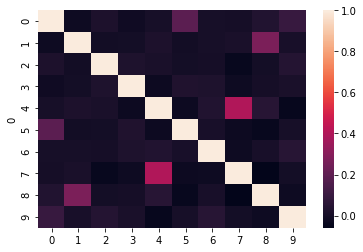

Key:
0  
##If you have users that use P2P, you will need to tweak this and all wireless routers
1   
Wizard[-2][u] ##The Wizard is particularly sinister
2  
## Apple is already being outpaced by Creative Labs and Sony on the battery front, and just about any non-Apple player allows you more compatibility with download services than Apple's iTunes-only program
3 
heavy[-1][u]##Only problem is that is a bit heavy
4 
##I am SO thankful I got that advice when I did because I had the Diaper Genie on my registry aforementioned to her warning
5 
grip[-1],chuck[-1],collet[-1]##It's oftentimes hard to get a good grip on the router, activate the chuck lock, and get enough muscle behind the wrench to get the collet loosened up
6 
[t]
S100[+3][cc]##This is my second digital camera, but I'm much more impressed with the Canon S100 Digital Elph than I EVER was with my Kodak DC240
7 
size[+1]##look at the size of it!
##Any diaper pail, if you leave it for long enough, is going to smell
8   
##It may t

In [611]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


### Random forest and logistic regression 

In [612]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier(n_estimators=200,max_depth=10,) 
train = rfc.fit(X_train_lsa, y_train)

print('Training set score:', rfc.score(X_train_lsa, y_train))
print('\nTest set score:', rfc.score(X_test_lsa, y_test))

Training set score: 0.8832720588235294

Test set score: 0.6336088154269972


Not as much overfitting this time. let't look at linear regression

In [659]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = 'liblinear',multi_class='auto',) # No need to specify l2 as it's the default. But we put it for demonstration.
train = lr.fit(X_train_lsa, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train_lsa, y_train))
print('\nTest set score:', lr.score(X_test_lsa, y_test))

(2176,) (2176,)
Training set score: 0.7325367647058824

Test set score: 0.6721763085399449


In [661]:
from sklearn.model_selection import cross_val_score
pred = lr.predict(X_test_lsa)
cross_val_score(lr,X_train_lsa,y_train,cv=10).mean()

0.6742336572833676

Looks like linear regression with TF-IDF is the best model. Next will be and attemt to increase the score by 5 points.

## Attempt to increase score by 5

I'll attemt to increase the score by adding some more cleaning.

In [634]:
Canon_PowerShot_SD500 = product_reviews_2.raw('Canon_PowerShot_SD500.txt')
Canon_S100=  product_reviews_2.raw( 'Canon_S100.txt')
Diaper_Champ = product_reviews_2.raw('Diaper_Champ.txt')
Hitachi_route =  product_reviews_2.raw('Hitachi_router.txt')
Linksys_Router = product_reviews_2.raw('Linksys_Router.txt')
MicroMP3 = product_reviews_2.raw('Canon_PowerShot_SD500.txt')
Nokia_6600 = product_reviews_2.raw('Nokia_6600.txt')
ipod = product_reviews_2.raw('ipod.txt')
norton = product_reviews_2.raw('norton.txt')
 

In [635]:
Canon_PowerShot_SD500_sents =[[sent, "camera"] for sent in Canon_PowerShot_SD500.split(".")]
Canon_S100_sents = [[sent, "camera"] for sent in Canon_S100.split(".")]
Diaper_Champ_sents = [[sent, "diaper_machine"] for sent in Diaper_Champ.split(".")]
Hitachi_route_sents = [[sent, "router"] for sent in Hitachi_route.split(".")]
Linksys_Router_sents = [[sent, "router"] for sent in Linksys_Router.split(".")]
MicroMP3_sents = [[sent, "mp3_player"] for sent in MicroMP3.split(".")]
aNokia_6600_sents = [[sent, "phone"] for sent in Nokia_6600.split(".")]
ipod_sents = [[sent, "mp3_player"] for sent in ipod.split(".")]
norton_sents = [[sent, "AV_software"] for sent in norton.split(".")]
 

In [636]:
def clean_txt(text):    
    #text = text.lower() 
    text = re.sub(r'^[^ ]*', '', text)
    text = re.sub("[^a-zA-Z.' ]+", " ", text)
    text = re.sub('\[.*?\]', " ", text)
    text = re.sub('\w*\d\w*', '', text)
    #text = " ".join(text.split()).strip()

    return text;

In [637]:
sentences[0] = sentences[0].apply(lambda x: clean_txt(str(x)))

In [638]:
tech = pd.DataFrame(Canon_PowerShot_SD500_sents+Canon_S100_sents+Diaper_Champ_sents+
                         Hitachi_route_sents+Linksys_Router_sents+MicroMP3_sents+aNokia_6600_sents+ipod_sents+norton_sents)

In [639]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test,y_train,y_test = train_test_split(tech[0],tech[1], test_size=0.4, random_state=0)

# function to convert to lemmas
def lemmas(text):
    text = nlp(text)
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    return allwords;
    


vectorizer = TfidfVectorizer(tokenizer=lemmas, # get lemmas from SpaCy
                             max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
#Applying the vectorizer
X_train_tfidf=vectorizer.fit_transform(X_train)
print("Number of features: %d" % X_train_tfidf.get_shape()[1])
X_test_tfidf = vectorizer.transform(X_test)
  

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1675
Original sentence:  
##I sincerely question the CNET reviewer's ability and/or their bias
Tf_idf vector: {'router': 0.21363780075707028, 'hard': 0.30772385619621256, 'good': 0.21535669144366698, 'chuck': 0.41087857655521154, 'lock': 0.35930121637571205, 'wrench': 0.4270719978699523, 'collet': 0.3880552310889314, 'loosen': 0.4270719978699523}


In [640]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

 

Percent variance captured by all components: 42.0743067641299


In [657]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = 'liblinear',multi_class='auto',C=100000) # No need to specify l2 as it's the default. But we put it for demonstration.
train = lr.fit(X_train_lsa, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train_lsa, y_train))
print('\nTest set score:', lr.score(X_test_lsa, y_test))

(2176,) (2176,)
Training set score: 0.7734375

Test set score: 0.6728650137741047


In [658]:
from sklearn.model_selection import cross_val_score
pred = lr.predict(X_test_lsa)
cross_val_score(lr,X_train_lsa,y_train,cv=10).mean()

0.6614373033756467